**CURSO**: Análisis Geoespacial, Departamento de Geociencias y Medio Ambiente, Universidad Nacional de Colombia - sede Medellín <br/>
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several sources, but specially from the courses and book open and freely published by [Dani Arribas-Bel](http://darribas.org/) -  University of Liverpool & - Sergio Rey - [Center for Geospatial Sciences, University of California, Riverside](http://spatial.ucr.edu/peopleRey.html). Every effort has been made to trace copyright holders of the materials used in this book. The author apologies for any unintentional omissions and would be pleased to add an acknowledgment in future editions. 

# Guide to Choropleth Maps

In [1]:
import warnings
warnings.filterwarnings('ignore')
# %matplotlib inline

## Principles


Choropleth maps play a prominent role in geographic data science as they allow
us to display non-geographic attributes or variables on a geographic map. The
word choropleth stems from the root "choro", meaning "region". As such
choropleth maps represent data at the region level, and are appropriate for
areal unit data where each observation combines a value of an attribute and a
geometric figure, usually a polygon. Choropleth maps derive from an earlier era
where cartographers faced technological constraints that precluded the use of
unclassed maps where each unique attribute value could be represented by a
distinct symbol or color. Instead, attribute values were grouped into a smaller
number of classes, usually not more than 12. Each class was associated with a
unique symbol that was in turn applied to all observations with attribute values
falling in the class.

Although today these technological constraints are no longer binding, and
unclassed mapping is feasible, there are still good reasons for adopting a
classed approach. Chief among these is to reduce the cognitive load involved in
parsing the complexity of an unclassed map. A choropleth map reduces this
complexity by drawing upon statistical and visualization theory to provide an
effective representation of the spatial distribution of the attribute values
across the areal units. 

The effectiveness of a choropleth map will be a
function of the choice of classification scheme together with the color or
symbolization strategy adopted. In broad terms, the classification scheme
defines the number of classes as well as the rules for assignment, while the
symbolization should convey information about the value differentiation across
the classes.

In this chapter we first discuss the approaches used to classify attribute
values. This is followed by an overview of color theory and the implications of
different color schemes for effective map design. We combine theory and practice
by exploring how these concepts are implemented in different Python packages,
including `geopandas`, and `PySAL`.

In this session, we will build on all we have learnt so far about loading and manipulating (spatial) data and apply it to one of the most commonly used forms of spatial analysis: choropleths. Remember these are maps that display the spatial distribution of a variable encoded in a color scheme, also called palette. Although there are many ways in which you can convert the values of a variable into a specific color, we will focus in this context only on a handful of them, in particular:

- Unique values

- Equal interval

- Quantiles

- Fisher-Jenks

Before all this mapping fun, let us get the importing of libraries and data loading out of the way:


In [ ]:
!pip install pysal

## Quantitative data classification 

Data classification considers the problem of 
partitioning the attribute values into mutually exclusive and exhaustive
groups. The precise manner in which this is done will be a function of the
measurement scale of the attribute in question. For quantitative attributes
(ordinal, interval, ratio scales) the classes will have an explicit ordering.
More formally, the classification problem is to define class boundaries such
that

$$
c_j < y_i \le  c_{j+1} \ \forall y_i \in C_{j}
$$

where $y_i$ is the
value of the attribute for spatial location $i$, $j$ is a class index, and $c_j$
represents the lower bound of interval $j$.

Different classification schemes obtain from their definition of the class
boundaries. The choice of the classification scheme should take into
consideration the statistical distribution of the attribute values.

To illustrate these considerations, we will examine regional income data for the
32 Mexican states used in the paper by {cite}`Rey_2010`. The variable we focus on is per capita gross domestic product
for 1940 (PCGDP1940):

In [ ]:
import geopandas as gpd
print(gpd.datasets.available)

['naturalearth_cities', 'naturalearth_lowres', 'nybb']


In [ ]:
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


Which displays the following statistical distribution for pop_est:

C:\Users\usuario\miniconda3\envs\geo\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\usuario\miniconda3\envs\geo\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


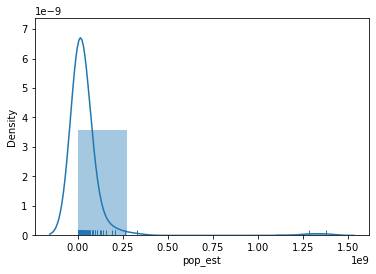

In [ ]:
h = seaborn.distplot(gdf['pop_est'], bins=5, rug=True);

In [ ]:
gdf['pop_est'].describe()

count    1.770000e+02
mean     4.171237e+07
std      1.459691e+08
min      1.400000e+02
25%      3.360148e+06
50%      9.961396e+06
75%      2.938430e+07
max      1.379303e+09
Name: pop_est, dtype: float64

For quantitative attributes we first sort the data by their value, such that x0≤x2…≤xn−1. For a prespecified number of classes k, the classification problem boils down to selection of k−1 break points along the sorted values that separate the values into mutually exclusive and exhaustive groups.

In fact, the determination of the histogram above can be viewed as one approach to this selection. The method seaborn.distplot uses the matplotlib hist function under the hood to determine the class boundaries and the counts of observations in each class. In the figure, we have five classes which can be extracted with an explicit call to the hist function:

In [ ]:
counts, bins, patches = h.hist(gdf['pop_est'], bins=5)

The counts object captures how many observations each category in the classification has:

In [ ]:
counts

array([174.,   1.,   0.,   0.,   2.])

The bin object stores these break points we are interested in when considering classification schemes (the patches object can be ignored in this context, as it stores the geometries of the histogram plot):

In [ ]:
bins

array([1.40000000e+02, 2.75860666e+08, 5.51721192e+08, 8.27581719e+08,
       1.10344224e+09, 1.37930277e+09])

This yields 5 bins, with the first having a lower bound of 140 and an upper bound of 2.758e+08 which contains 1 observation. The determination of the
interval width ($w$) and the number of bins in `seaborn` is based on the Freedman-Diaconis rule:

$$
w = 2 * IQR * n^{-1/3}
$$

where $IQR$ is the inter quartile
range of the attribute values. Given $w$ the number of bins ($k$) is:

$$k=(max-
min)/w.$$

Below we present several approaches to create these break points that follow criteria that can be of interest in different contexts, as they focus on different priorities.
 
### Equal Intervals

The Freedman-Diaconis approach provides a rule to determine the width and, in
turn, the number of bins for the classification. This is a special case of a
more general classifier known as "equal intervals", where each of the bins has
the same width in the value space. For a given value of $k$, equal intervals
classification splits the range of the attribute space into $k$ equal length
intervals, with each interval having a width $w = \frac{x_0 - x_{n-1}}{k}$. Thus
the maximum class is $(x_{n-1}-w, x_{n-1}]$ and the first class is $(-\infty,
x_{n-1} - (k-1)w]$.

Equal intervals have the dual advantages of simplicity and ease of
interpretation. However, this rule only considers the extreme values of the
distribution and, in some cases, this can result in one or more classes being
sparse. This is clearly the case in our income dataset, as the majority of the
values are placed into the first two classes leaving the last three classes
rather sparse:

In [ ]:
ei5 = mapclassify.EqualInterval(gdf['pop_est'], k=5)
ei5

EqualInterval                         

           Interval              Count
--------------------------------------
[       140.00,  275860666.20] |   174
( 275860666.20,  551721192.40] |     1
( 551721192.40,  827581718.60] |     0
( 827581718.60, 1103442244.80] |     0
(1103442244.80, 1379302771.00] |     2

Note that each of the intervals, however, has equal width of w=4093.8. This value of k=5 also coincides with the default classification in the Seaborn histogram displayed in Figure 1. It should also be noted that the first class is closed on the lower bound, in contrast to the general approach defined in Equation (1).

### Quantiles
To avoid the potential problem of sparse classes, the quantiles of
the distribution can be used to identify the class boundaries. Indeed, each
class will have approximately $\mid\frac{n}{k}\mid$ observations using the quantile
classifier. If $k=5$ the sample quintiles are used to define the upper limits of
each class resulting in the following classification:

In [ ]:
q5 = mapclassify.Quantiles(gdf.pop_est, k=5)
q5

Quantiles                             

           Interval              Count
--------------------------------------
[       140.00,    2348401.60] |    36
(   2348401.60,    6195124.20] |    35
(   6195124.20,   14323146.80] |    35
(  14323146.80,   38250202.20] |    35
(  38250202.20, 1379302771.00] |    36

Note that while the numbers of values in each class are roughly equal, the widths of the first four intervals are rather different:

In [ ]:
q5.bins[1:]-q5.bins[:-1]

array([3.84672260e+06, 8.12802260e+06, 2.39270554e+07, 1.34105257e+09])

While quantiles does avoid the pitfall of sparse classes, this classification is
not problem free. The varying widths of the intervals can be markedly different
which can lead to problems of interpretation. A second challenge facing quantiles
arises when there are a large number of duplicate values in the distribution
such that the limits for one or more classes become ambiguous. For example, if one had a variable with $n=20$ but 10 of the observations took on the same value which was the minimum observed, then for values of $k>2$, the class boundaries become ill-defined since a simple rule of splitting at the $n/k$ ranked observed value would depend upon how ties are treated when ranking.

### Mean-standard deviation

Our third classifer uses the sample mean $\bar{x} =
\frac{1}{n} \sum_{i=1}^n x_i$ and sample standard deviation $s = \sqrt{
\frac{1}{n-1} \sum_{i=1}^n (x_i - \bar{x})  }$ to define class boundaries as
some distance from the sample mean, with the distance being a multiple of the
standard deviation. For example, a common definition for $k=5$ is to set the
upper limit of the first class to two standard deviations ($c_{0}^u = \bar{x} - 2 s$), and the intermediate
classes to have upper limits within one standard deviation ($c_{1}^u = \bar{x}-s,\ c_{2}^u = \bar{x}+s, \ c_{3}^u
= \bar{x}+2s$). Any values greater (smaller) than two standard deviations above (below) the mean
are placed into the top (bottom) class.

In [ ]:
msd = mapclassify.StdMean(gdf['pop_est'])
msd

StdMean                               

           Interval              Count
--------------------------------------
(         -inf, -250225811.84] |     0
(-250225811.84, -104256721.00] |     0
(-104256721.00,  187681460.68] |   170
( 187681460.68,  333650551.53] |     5
( 333650551.53, 1379302771.00] |     2

This classifier is best used when data is normally distributed or, at least, when the sample mean is a meaningful measure to anchor the classification around. Clearly this is
not the case for our income data as the positive skew results in a loss of
information when we use the standard deviation. The lack of symmetry leads to
an inadmissible upper bound for the first  class as well as a concentration of the
vast majority of values in the middle class.

### Maximum Breaks

The maximum breaks classifier decides where to set the break points between
classes by considering the difference between sorted values. That is, rather
than considering a value of the dataset in itself, it looks at how appart each
value is from the next one in the sorted sequence. The classifier then places
the the $k-1$ break points in between the pairs of values most stretched apart from
each other in the entire sequence, proceeding in descending order relative to
the size of the breaks:

In [ ]:
mb5 = mapclassify.MaximumBreaks(gdf['pop_est'], k=5)
mb5

MaximumBreaks                         

           Interval              Count
--------------------------------------
[       140.00,  233967065.00] |   173
( 233967065.00,  293603265.00] |     1
( 293603265.00,  804280851.00] |     1
( 804280851.00, 1330619341.00] |     1
(1330619341.00, 1379302771.00] |     1

Maximum breaks is an appropriate approach when we are interested in making sure
observations in each class are separated from those in neighboring classes. As
such, it works well in cases where the distribution of values is not unimodal.
In addition, the algorithm is relatively fast to compute. However, its
simplicitly can sometimes cause unexpected results. To the extent in only
considers the top $k-1$ differences between consecutive values, other more nuanced
within-group differences and dissimilarities can be ignored.

### Box-Plot

The box-plot classification is a blend of the quantile and
standard deviation classifiers. Here $k$ is predefined to six, with the upper limit of class 0 set
to $q_{0.25}-h \, IQR$. $IQR = q_{0.75}-q_{0.25}$ is the
inter-quartile range; $h$ corresponds to the hinge, or the multiplier of the $IQR$ to obtain the bounds of the whiskers. The lower limit of the sixth class is set to $q_{0.75}+h \,
IQR$. Intermediate classes have their upper limits set to the 0.25, 0.50 and
0.75 percentiles of the attribute values.

In [ ]:
bp = mapclassify.BoxPlot(gdf['pop_est'])
bp

BoxPlot                               

           Interval              Count
--------------------------------------
(         -inf,  -35676075.50] |     0
( -35676075.50,    3360148.00] |    45
(   3360148.00,    9961396.00] |    44
(   9961396.00,   29384297.00] |    44
(  29384297.00,   68420520.50] |    25
(  68420520.50, 1379302771.00] |    19

Any values falling into either of the extreme classes are defined as outlers.
Note that because the income values are non-negative by definition, the lower
outlier class has an inadmissible upper bound meaning that lower outliers would
not be possible for this sample.

The default value for the hinge is $h=1.5$ in
PySAL. However, this can be specified by the user for an alternative classification:

In [ ]:
bp1 = mapclassify.BoxPlot(gdf['pop_est'], hinge=1)
bp1

BoxPlot                               

           Interval              Count
--------------------------------------
(         -inf,  -22664001.00] |     0
( -22664001.00,    3360148.00] |    45
(   3360148.00,    9961396.00] |    44
(   9961396.00,   29384297.00] |    44
(  29384297.00,   55408446.00] |    21
(  55408446.00, 1379302771.00] |    23

Doing so will affect the definition of the outlier classes, as well as the
neighboring internal classes.

### Head-Tail Breaks

The head tail algorithm {cite}`Jiang_2013` is based on a recursive partioning of the data using splits around
iterative means. The splitting process continues until the distributions within each of
the classes no longer display a heavy-tailed distribution in the sense that
there is a balance between the number of smaller and larger values assigned to
each class.

In [ ]:
ht = mapclassify.HeadTailBreaks(gdf['pop_est'])
ht

HeadTailBreaks                        

           Interval              Count
--------------------------------------
[       140.00,   41712369.84] |   145
(  41712369.84,  182567501.00] |    25
( 182567501.00,  550193675.00] |     5
( 550193675.00, 1330619341.00] |     1
(1330619341.00, 1379302771.00] |     1

For data with a heavy-tailed distribution, such as power law and log normal
distributions, the head tail breaks classifier  can be particularly
effective.

### Jenks Caspall

This approach, as well as the following two, tackles the classification
challenge from a heuristic perspective, rather than from deterministic one.
Originally proposed by {cite}`Jenks_1971`, this algorithm aims to minimize
the sum of absolute deviations around class means. The approach begins with a
prespecified number of classes and an arbitrary initial set of class breaks -
for example using quintiles. The algorithm attempts to improve the objective
function by considering the movement of observations between adjacent classes.
For example, the largest value in the lowest quintile would be considered for
movement into the second quintile, while the lowest value in the second
quintile would be considered for a possible move into the first quintile. The
candidate move resulting in the largest reduction in the objective function
would be made, and the process continues until no other improving moves are
possible.

In [ ]:
numpy.random.seed(12345)
jc5 = mapclassify.JenksCaspall(gdf['pop_est'], k=5)
jc5

JenksCaspall                          

           Interval              Count
--------------------------------------
[       140.00,    6653210.00] |    73
(   6653210.00,   20107509.00] |    46
(  20107509.00,   55123814.00] |    35
(  55123814.00,  157826578.00] |    16
( 157826578.00, 1379302771.00] |     7

In [ ]:
numpy.random.seed(12345)
fj5 = mapclassify.FisherJenks(gdf['pop_est'], k=5)
fj5

FisherJenks                           

           Interval              Count
--------------------------------------
[       140.00,   22409381.00] |   121
(  22409381.00,   68414135.00] |    37
(  68414135.00,  157826578.00] |    12
( 157826578.00,  326625791.00] |     5
( 326625791.00, 1379302771.00] |     2

### Fisher Jenks

The second optimal algorithm adopts a dynamic programming approach to minimize
the sum of the absolute deviations around class medians. In contrast to the
Jenks-Caspall approach, Fisher-Jenks is guaranteed to produce an optimal
classification for a prespecified number of classes:

### Max-p

Finally, the max-p classifiers adopts the algorithm underlying the max-p region
building method {cite}`Duque_2011` to the case of map classification. It is similar in spirit to
Jenks Caspall in that it considers greedy swapping between adjacent classes to
improve the objective function. It is a heuristic, however, so unlike
Fisher-Jenks, there is no optimial solution guaranteed:

In [ ]:
mp5 = mapclassify.MaxP(gdf['pop_est'], k=5)
mp5

MaxP                                  

           Interval              Count
--------------------------------------
[       140.00,    2051363.00] |    33
(   2051363.00,   10768477.00] |    61
(  10768477.00,   15460732.00] |    14
(  15460732.00,   38476269.00] |    34
(  38476269.00, 1379302771.00] |    35

### Comparing Classification schemes

As a special case of clustering, the definition of
the number of classes and the class boundaries pose a problem to the map
designer. Recall that the Freedman-Diaconis rule was said to be optimal,
however, the optimality necessitates the specification of an objective function.
In the case of Freedman-Diaconis, the objective function is to minimize the
difference between the area under estimated kernel density based on the sample
and the area under the theoretical population distribution that generated the
sample.

This notion of statistical fit is an important one. However, it is not the
only consideration when evaluating classifiers for the purpose of choropleth
mapping. Also relevant is the spatial distribution of the attribute values and
the ability of the classifier to convey a sense of that spatial distribution. As
we shall see, this is not necessarily directly related to the statistical
distribution of the attribute values. We will return to a joint consideration of both
the statistical and spatial distribution of the attribute values in comparison
of classifiers below.

For map classification, one optimiality criterion that
can be used is a measure of fit. In PySAL the "absolute deviation around class
medians" (ADCM) is calculated and provides a measure of fit that allows for
comparison of alternative classifiers for the same value of $k$.

To see this, we can compare different classifiers for $k=5$ on the Mexico data:

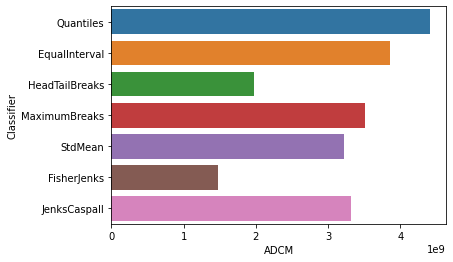

In [ ]:
class5 = q5, ei5, ht, mb5, msd, fj5, jc5
fits = numpy.array([ c.adcm for c in class5])
data = pandas.DataFrame(fits)
data['classifier'] = [c.name for c in class5]
data.columns = ['ADCM', 'Classifier']
ax = seaborn.barplot(y='Classifier', x='ADCM', data=data)

As is to be expected, the Fisher-Jenks classifier dominates all other k=5 classifiers with an ACDM of 23,729. Interestingly, the equal interval classifier performs well despite the problems associated with being sensitive to the extreme values in the distribution. The mean-standard deviation classifier has a very poor fit due to the skewed nature of the data and the concentrated assignment of the majority of the observations to the central class.

The ADCM provides a global measure of fit which can be used to compare the alternative classifiers. As a complement to this global perspective, it can be revealing to consider how each of the spatial observations was classified across the alternative approaches. To do this we can add the class bin attribute (yb) generated by the PySAL classifiers as additional columns in the data frame and present these jointly in a table:

In [ ]:
gdf['q540'] = q5.yb
gdf['ei540'] = ei5.yb
gdf['ht40'] = ht.yb
gdf['mb540'] = mb5.yb
gdf['msd40'] = msd.yb
gdf['fj540'] = fj5.yb
gdf['jc540'] = jc5.yb

In [ ]:
gdfs = gdf.sort_values('pop_est')

In [ ]:
def highlight_values(val):
    if val==0:
        return 'background-color: %s' % '#ffffff'
    elif val==1:
        return 'background-color: %s' % '#e0ffff'
    elif val==2:
        return 'background-color: %s' % '#b3ffff'
    elif val==3:
        return 'background-color: %s' % '#87ffff'
    elif val==4:
        return 'background-color: %s' % '#62e4ff'
    else:
        return ''

In [ ]:
t = gdfs[['name', 'pop_est', 'q540', 'ei540', 'ht40', 'mb540', 'msd40', 'fj540', 'jc540']]
t.style.applymap(highlight_values)

,name,pop_est,q540,ei540,ht40,mb540,msd40,fj540,jc540
23,Fr. S. Antarctic Lands,140,0,0,0,0,2,0,0
20,Falkland Is.,2931,0,0,0,0,2,0,0
159,Antarctica,4050,0,0,0,0,2,0,0
22,Greenland,57713,0,0,0,0,2,0,0
160,N. Cyprus,265100,0,0,0,0,2,0,0
134,New Caledonia,279070,0,0,0,0,2,0,0
89,Vanuatu,282814,0,0,0,0,2,0,0
19,Bahamas,329988,0,0,0,0,2,0,0
144,Iceland,339747,0,0,0,0,2,0,0
39,Belize,360346,0,0,0,0,2,0,0


Inspection of this table reveals a number of interesting results. First, the only city that is treated consistantly across the k=5 classifiers is China which is placed in the highest class by all classifiers.

Finally, we can consider a meso-level view of the clasification results by comparing the number of values assigned to each class across the different classifiers:

In [ ]:
pandas.DataFrame({c.name: c.counts for c in class5},
                 index=['Class-{}'.format(i) for i in range(5)])

,Quantiles,EqualInterval,HeadTailBreaks,MaximumBreaks,StdMean,FisherJenks,JenksCaspall
Class-0,36,174,145,173,0,121,73
Class-1,35,1,25,1,0,37,46
Class-2,35,0,5,1,170,12,35
Class-3,35,0,1,1,5,5,16
Class-4,36,2,1,1,2,2,7


Doing so highlights the similarities between Fisher Jenks and equal intervals as
the distribution counts are very similar as the two approaches agree on all 17
states assigned to the first class. Indeed, the only observation that
distinguishes the two classifiers is the treatment of Baja California Sur which
is kept in class 1 in equal intervals, but assigned to class 2 by Fisher Jenks.

## Color

Having considered the evaluation of the statisitcal distribution of
the attribute values and the alternative classification approaches, the next
step is to select the symbolization and color scheme. Together with the choice of classifier, these will determine the overall
effectiveness of the choropleth map in representing the spatial
distribution of the attribute values.

<AxesSubplot:>

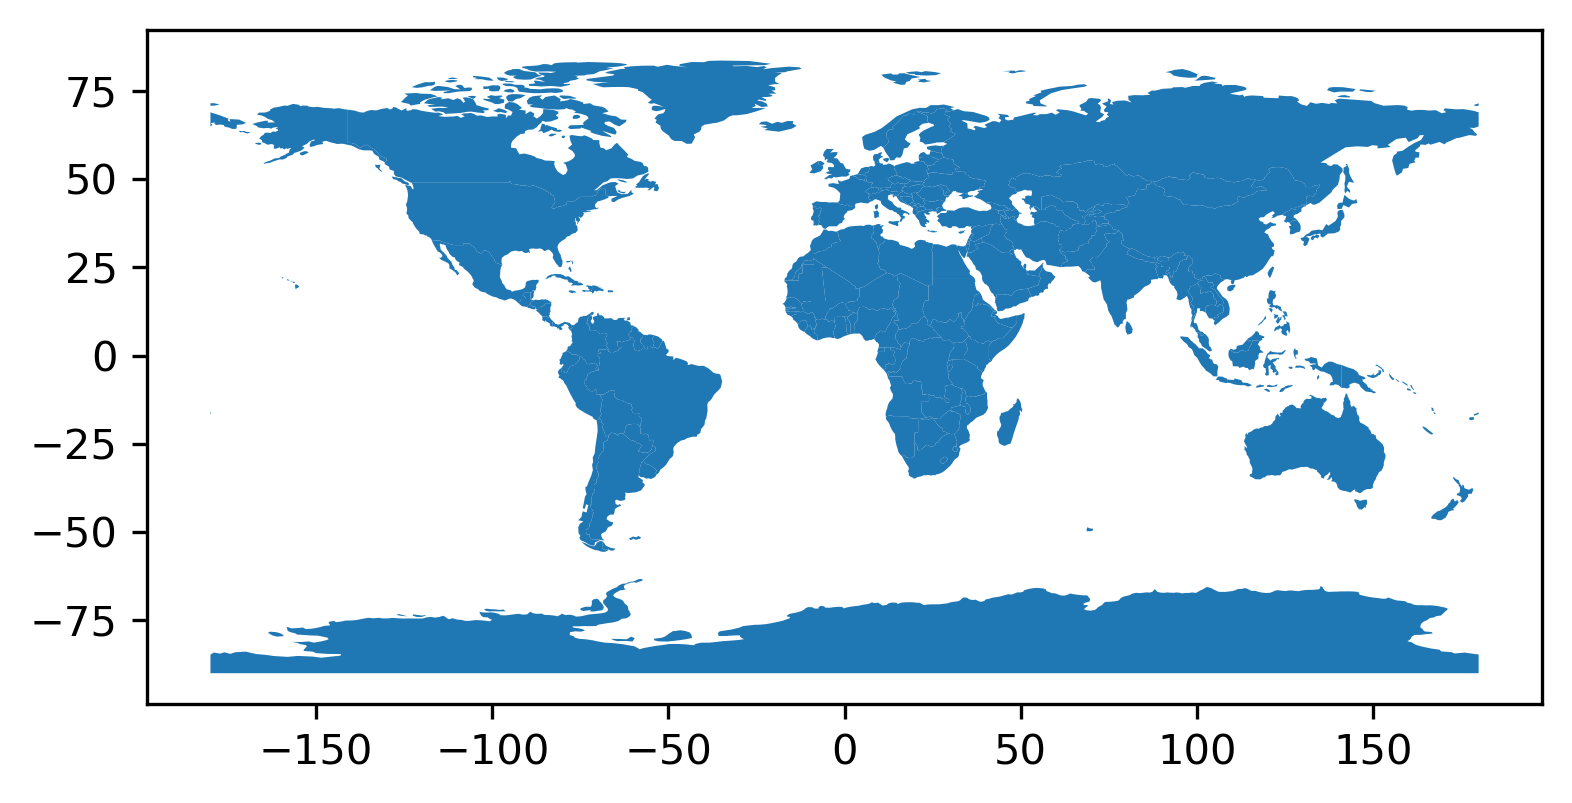

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(dpi=300)
gdf.plot(ax=ax)

<AxesSubplot:>

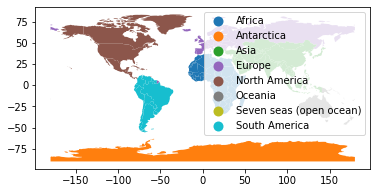

In [ ]:
gdf.plot(column="continent", categorical=True, legend=True)

Note how we are using the same approach as for basic maps, the command plot, but we now need to add the argument column to specify which column in particular is to be represented.

- Since the variable is categorical we need to make that explicit by setting the argument categorical to True.

- As an optional argument, we can set legend to True and the resulting figure will include a legend with the names of all the values in the map.

- Unless we specify a different colormap, the selected one respects the categorical nature of the data by not implying a gradient or scale but a qualitative structure.



Prior to examining the attribute values it is important to note that the
spatial units for these states are far from homogenous in their shapes and
sizes. This can have major impacts on our brain's pattern recognition capabilities
as we tend to be drawn to the larger polygons. Yet, when we considered the
statistical distribution above, each observation was given equal weight. Thus,
the spatial distribution becomes more complicated to evaluate from a visual and
statistical perspective.

With this qualification in mind, we will explore the construction of choropleth
maps using geopandas:

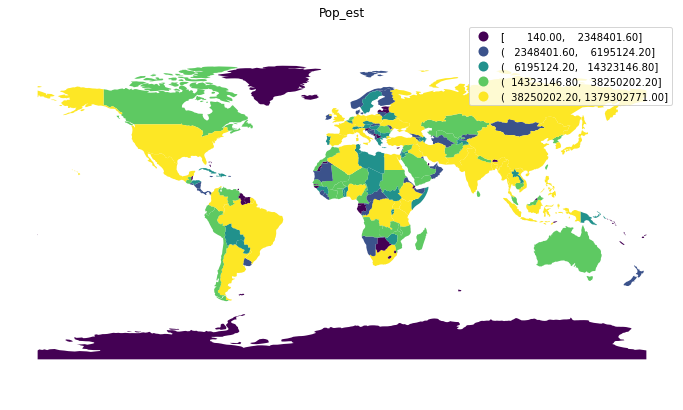

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 7))
gdf.plot(ax=ax, column='pop_est', legend=True, scheme='Quantiles')
ax.set_axis_off()
ax.set_title('Pop_est')
plt.axis('equal')
plt.show()

In [ ]:
Note that the default for the legend is two report two decimal places. If we desire, this can be changed by overriding the `fmt` parameter:

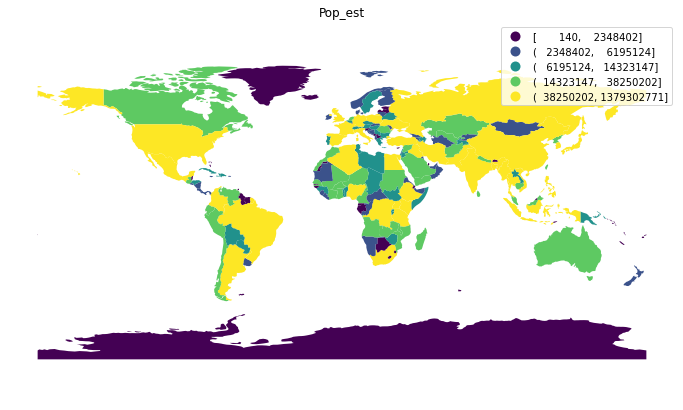

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 7))
gdf.plot(ax=ax, column='pop_est', legend=True, scheme='Quantiles', legend_kwds={'fmt':'{:.0f}'})
ax.set_axis_off()
ax.set_title('Pop_est')
plt.axis('equal')
plt.show()

The default color map used by geopandas is viridis, which is a multi-hue
sequential scheme, with the darker (ligher) hues representing lower (higher)
values for the attribute in question. The choice of a color scheme for a
choropleth map should be based on the type of variable under consideration
{cite}`Brewer1997mapping`. Generally, a distinction is drawn between three
types of numerical attributes:

- sequential
- diverging
- qualitative

### Sequential Color Schemes
Our attribute is measured in dollars and is characterized as a *sequential* attribute. To choose an appropriate sequential scheme we can override the `cmap` parameter:

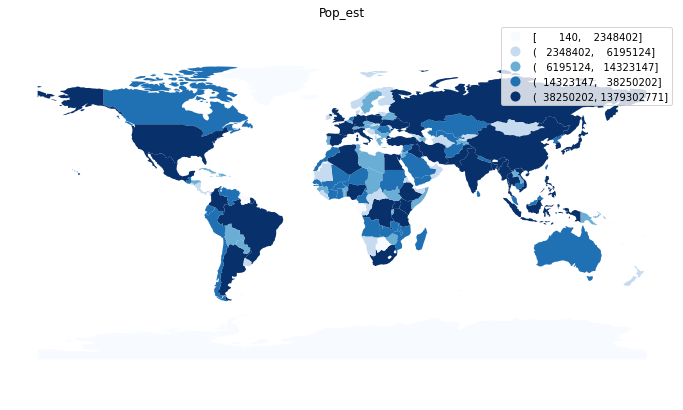

In [ ]:
f, ax = plt.subplots(1, figsize=(12,7))
gdf.plot(ax=ax, column='pop_est', legend=True, scheme='Quantiles', legend_kwds={'fmt':'{:.0f}'}, \
         cmap='Blues')
ax.set_axis_off()
ax.set_title('Pop_est')
plt.axis('equal')
plt.show()

which now uses a single-hue sequent,ial color map with the lighter shades representing lower values. One difficulty with this map is that the poor states in the southern portion of Mexico blend into the background of the map display. This can be adjusted by overriding the edgecolor:

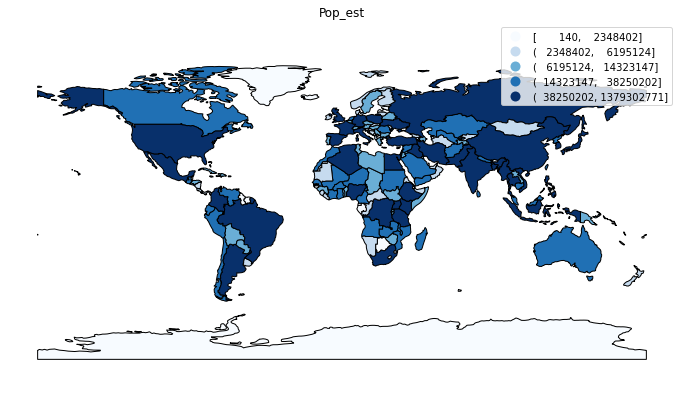

In [ ]:
f, ax = plt.subplots(1, figsize=(12,7))
gdf.plot(ax=ax, column='pop_est', legend=True, scheme='Quantiles', legend_kwds={'fmt':'{:.0f}'}, \
         cmap='Blues', edgecolor='k')
ax.set_axis_off()
ax.set_title('Pop_est')
plt.axis('equal')
plt.show()

In [ ]:
# We will first normalize the population and GDP values into [0,1] range
# color.to_hex takes a (r, g, b) tuple as input and returns the hex value
# the r, g, b values are expected to be in the [0,1] range
# we will assign r to population and g to GDP
# we will keep b as 0
pop_values = gdf['pop_est'] / gdf['pop_est'].max()
gdp_values = gdf['gdp_md_est'] / gdf['gdp_md_est'].max()
rgb_values = [(x,y,z) for x, y, z in zip(pop_values, gdp_values, [0]*len(pop_values))]
gdf['Color'] = [colors.to_hex(rgb) for rgb in rgb_values]

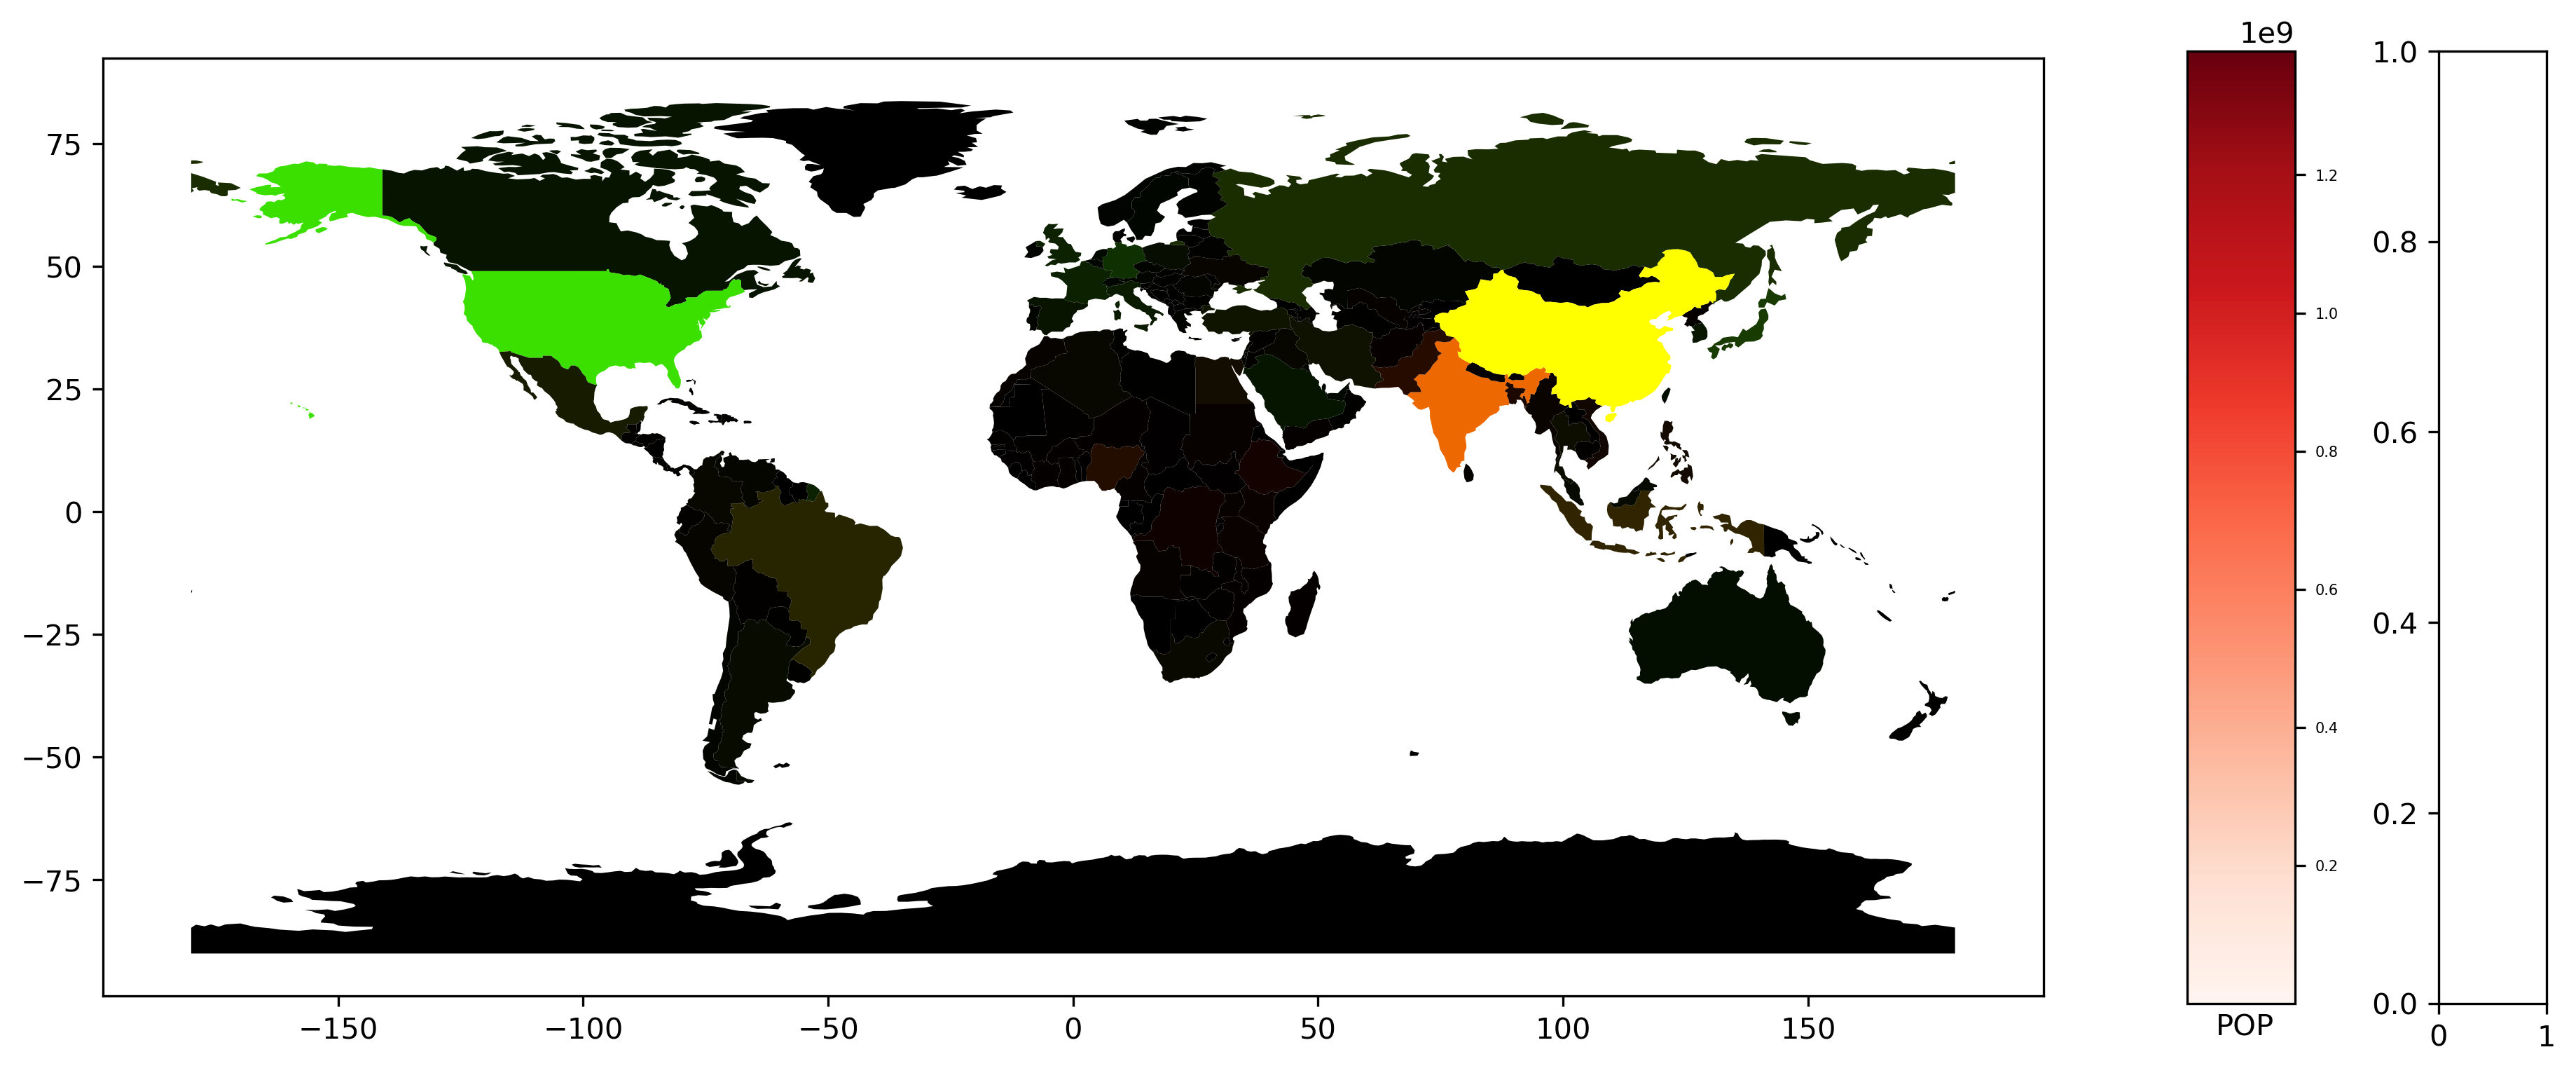

In [ ]:
fig, axes = plt.subplots(1, 3, dpi=300,  figsize=(15, 6), gridspec_kw={'width_ratios': [18, 1, 1]})
gdf.plot(ax=axes[0], color=gdf['Color'])
from matplotlib import cm, colors
cmap = 'Reds'
norm = colors.Normalize(vmin=gdf['pop_est'].min(), vmax=gdf['pop_est'].max())
axes[1].tick_params(labelsize=5)
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=axes[1], orientation='vertical')
cb.set_label('POP',labelpad=-32, y=-.01, rotation=0)

## Zooming into the map
A general map of an entire region, or urban area, can sometimes obscure local patterns because they happen at a much smaller scale that cannot be perceived in the global view. One way to solve this is by providing a focus of a smaller part of the map in a separate figure. Although there are many ways to do this in Python, the most straightforward one is to reset the limits of the axes to center them in the area of interest.

As an example, let us consider the quantile map produced above:

<AxesSubplot:>

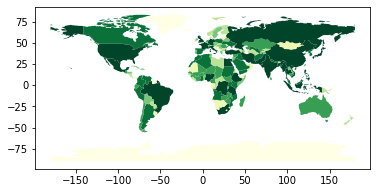

In [ ]:
gdf.plot(column="pop_est", scheme="quantiles", k=7, cmap="YlGn", legend=False)

If we want to focus around Colombia, the first step involves realising that such area of the map (the little dark green polygon in the SE centre of the map), falls within the coordinates of -80/-70W, and -5N/10N, roughly speaking. To display a zoom map into that area, we can do as follows:

(-80.0, -65.0)

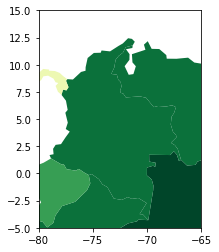

In [ ]:
# Setup the figure
f, ax = plt.subplots(1)
# Draw the choropleth
gdf.plot(column="pop_est", 
        scheme="quantiles", 
        k=7,
        cmap="YlGn",
        legend=False,
        ax=ax
       )
# Redimensionate X and Y axes to desired bounds
ax.set_ylim(-5, 15)
ax.set_xlim(-80, -65)

### Partial map

The approach above is straightforward, but not necessarily the most efficient one: not that, to generate a map of a potentially very small area, we effectively draw the entire (potentially very large) map, and discard everything except the section we want. This is not straightforward to notice at first sight, but what Python is doing in the code cell above is plottin the entire `db` object, and only then focusing the figure on the X and Y ranges specified in `set_xlim`/`set_ylim`.

Sometimes, this is required. For example, if we want to retain the same coloring used for the national map, but focus on the region around Mexico DF, this approach is the easiest one.

However, sometimes, we only need to plot the _geographical features_ within a given range, and we either don't need to keep the national coloring (e.g. we are using a single color), or we want a classification performed _only_ with the features in the region.

For these cases, it is computationally more efficient to select the data we want to plot first, and then display them through `plot`. For this, we can rely on the `cx` operator:

<AxesSubplot:>

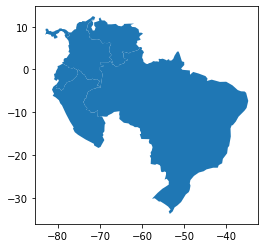

In [ ]:
subset = gdf.cx[-80:-65, -5:15]
subset.plot()

We query the range of spatial coordinates similarly to how we query indices with `loc`. Note however the result includes full geographic features, and hence the polygons with at least some area within the range are included fully. This results in a larger range than originally specified.

This approach is a "spatial slice". If you remember when we saw {ref}`non-spatial slices <lab_B:slices>` (enabled by the `loc` operator), this is a similar approach but our selection criteria, instead of subsetting by indices of the table, are based on the spatial coordinates of the data represented in the table.

Since the result is a `GeoDataFrame` itself, we can create a choropleth that is based only on the data in the subset:

<AxesSubplot:>

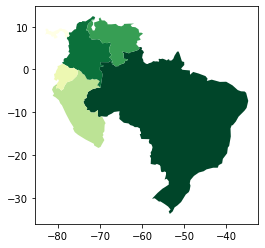

In [ ]:
subset.plot(column="pop_est", 
            scheme="quantiles", 
            k=7,
            cmap="YlGn",
            legend=False
           )

## Cartograms
Cartograms are maps that represent the spatial distribution of a variable not by encoding it in a color palette by rather by modifying geographical objects. There are many algorithms to distort the shapes of geographical entities according to values, some of them incredibly complicated and complex.

As an example of how to create a relatively straight-forward cartogram, we will convert polygons into points by using their centroids, and will define the size of the dot proportionally to the value of the variable we want to display, the IMD score in this case. We will adopt a different approach to plot points than we have done so far. This involves first extracting the coordinates of the points:

In [ ]:
pts = np.array([(pt.x, pt.y) for pt in gdf.centroid])

C:\Users\usuario\miniconda3\envs\geo\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


**NOTE**: The line of code above contains some elements that reflect more advanced Python programming that we have covered so far, so you should feel free to simply run it to extract the points.

---

If you are interested in the logic however, it uses a technique called "list comprehension", which can compress and entire `for` loop into a single line of code, producing more elegant and, to the trained eye, more readable code. Essentially, the line above can be unpacked into the following loop:

In [ ]:
pts = []
for pt in gdf.centroid:
    pts.append((pt.x, pt.y))
pts = np.array(pts)

Once we have extracted them, we can display them through the command `plt.scatter`. This is equivalent to the straightforward `plot`, or to loop over each point, with the difference that it will allow us to modify the size of the dots according to a variable:

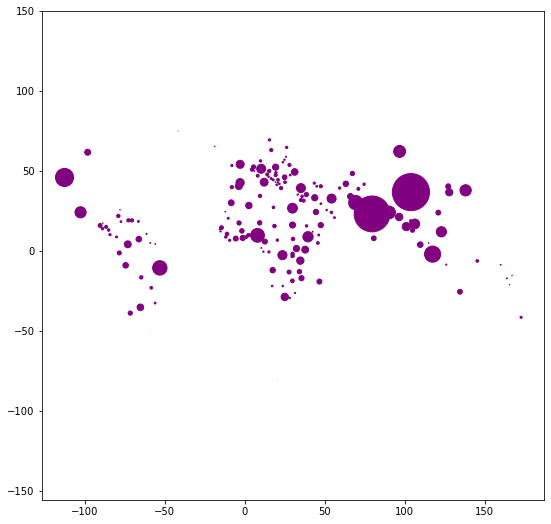

In [ ]:
# Set up figure and axes
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot the dots, using `imd_score` as a variable to modify
# the size of each dot
ax.scatter(pts[:, 0], pts[:, 1], c='purple', s=gdf['pop_est'].values/1000000)
# Keep axes proportionate
ax.axis("equal")
# Display
plt.show()

The command `plt.scatter` can also take some of the optional arguments we have learned before, such as color. Have a look at the help of the command ([link](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter)) and try modifying some of them to explore changes in the resulting plot.

## Conditional maps
Conditional maps are an attempt to explore multivariate relationships within a choropleth mapping context. In essence, they are figures composed by several choropleths in which the layout of each of them provides information about the subset of the original dataset represented. The idea is that a dataset can be subset based on one or two conditional variables, usually categorical, and only the observations that meet each characteristic are displayed in a given submap. Since they are combinations of choropleths, they build on everything we have learned about their creation. As an example, let us create a conditional map of IMD scores based on the dominating gender and marital status of each area.

From a Python perspective, creating conditional maps is a bit more intricate than standard choropleths because of the conditioning of the data and the arranging of the layout that needs to occur for the final figure to be produced. To be able to use the facetting machinery available in `seaborn`, we need to define a function that generates a choropleth with a given subset of the dataset:

In [ ]:
def map_subset(vals, db, color=None, norm=True):
    '''
    Internal function to pass to `FaceGrid` to build a single map
    ...
    
    Arguments
    ---------
    vals     : Series
               Values of the subplot to be mapped
    db       : GeoDataFrame
               Table with geometries
    color    : None
    '''
    ax = plt.gca()
    db.plot(color='0.8', edgecolor='0.8', linewidth=1., ax=ax)
    vari = vals.name
    if norm:
        db.reindex(vals.index).plot(column=vari, ax=ax, cmap='RdPu', linewidth=0., \
                               vmin=db[vari].min(), vmax=db[vari].max())
    else:
        db.reindex(vals.index).plot(column=vari, ax=ax, cmap='RdPu', linewidth=0.)
    ax.set_axis_off()
    return None

With this function in hand, we can use it to pass it on to the facetting functionality in `seaborn`, which then takes care of the actual subsetting of the data and proper alignment of the output figures:

In [ ]:
import seaborn as sns
g = sns.FacetGrid(gdf, row= "continent", col="name", \
                  margin_titles=True, size=5)
g.map(map_subset, "pop_est", db=gdf)
plt.tight_layout()
plt.show()

C:\Users\usuario\miniconda3\envs\geo\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
